In [ ]:
import scipp as sc
import numpy as np
import dataconfig # dataconfig produced via make_config.py

In [ ]:
def to_bin_centers(d, dim):
    edges = d.coords[dim].copy()
    del d.coords[dim]
    d.coords[dim] = 0.5 * (edges[dim, 1:] + edges[dim, :-1])

In [ ]:
def to_bin_edges(d, dim):
    centers = d.coords[dim].copy()
    del d.coords[dim]
    first = 1.5*centers[dim, 0] - 0.5*centers[dim, 1]
    last = 1.5*centers[dim, -1] - 0.5*centers[dim, -2]
    bulk = 0.5 * (centers[dim, 1:] + centers[dim, :-1])
    edges = sc.concatenate(first, bulk, dim)
    edges = sc.concatenate(edges, last, dim)
    d.coords[dim] = edges

In [ ]:
def map_to_bins(data, dim, edges):
    data = data.copy()
    to_bin_edges(data, dim)
    bin_width = data.coords[dim][dim,1:] - data.coords[dim][dim,:-1]
    bin_width.unit = sc.units.one
    data *= bin_width
    data = sc.rebin(data, dim, edges)
    bin_width = edges[dim,1:] - edges[dim,:-1]
    bin_width.unit = sc.units.one
    data /= bin_width
    return data

In [ ]:
path = dataconfig.data_root
direct_beam_file = 'DirectBeam_20feb_full_v3.dat'
moderator_file = 'ModeratorStdDev_TS2_SANS_LETexptl_07Aug2015.txt'
sample_run_number = 49338
sample_transmission_run_number = 49339
background_run_number = 49334
background_transmission_run_number = 49335

def load_larmor(run_number):
    return sc.neutron.load(filename=f'{path}/LARMOR000{run_number}.nxs')

def load_rkh(filename):
    return sc.neutron.load(
           filename=filename,
           mantid_alg='LoadRKH',
           mantid_args={'FirstColumnValue':'Wavelength'})

In [ ]:
%%time
sample_trans = load_larmor(sample_transmission_run_number)
sample = load_larmor(sample_run_number)

background_trans = load_larmor(background_transmission_run_number)
background = load_larmor(background_run_number)

In [ ]:
sample_pos_offset = sc.Variable(
    value=[0.0, 0.0, 0.30530],
    unit=sc.units.m,
    dtype=sc.dtype.vector_3_float64)
bench_pos_offset = sc.Variable(
    value=[0.0, 0.001, 0.0],
    unit=sc.units.m,
    dtype=sc.dtype.vector_3_float64)
for item in [sample, sample_trans, background, background_trans]:
    item.coords['sample_position'] += sample_pos_offset
    item.coords['position'] += bench_pos_offset

In [ ]:
wavelength_bins = sc.Variable(
    dims=['wavelength'],
    unit=sc.units.angstrom,
    values=np.geomspace(0.9, 13.5, num=110))

In [ ]:
def apply_masks(data):
    tof = data.coords['tof']
    data.masks['bins'] = sc.less(tof['tof',1:], 1500.0 * sc.units.us) | \
                         (sc.greater(tof['tof',:-1], 17500.0 * sc.units.us) & \
                          sc.less(tof['tof',1:], 19000.0 * sc.units.us))
    pos = sc.neutron.position(data)
    x = sc.geometry.x(pos)
    y = sc.geometry.y(pos)
    data.masks['beam-stop'] = sc.less(sc.sqrt(x*x+y*y), 0.045 * sc.units.m)
    data.masks['tube-ends'] = sc.greater(sc.abs(x), 0.36 * sc.units.m) # roughly all det IDs listed in original
    #MaskDetectorsInShape(Workspace=maskWs, ShapeXML=self.maskingPlaneXML) # irrelevant tiny wedge?

In [ ]:
def background_mean(data, dim, begin, end):
    coord = data.coords[dim]
    assert (coord.unit == begin.unit) and (coord.unit == end.unit)
    i = np.searchsorted(coord, begin.value)
    j = np.searchsorted(coord, end.value) + 1
    return data - sc.mean(data[dim, i:j], dim)

In [ ]:
def transmission_fraction(incident_beam, transmission):
    # Approximation based on equations in CalculateTransmission documentation
    # TODO proper implementation of mantid.CalculateTransmission
    return (transmission / transmission) * (incident_beam / incident_beam)
    #CalculateTransmission(SampleRunWorkspace=transWsTmp,
    #                      DirectRunWorkspace=transWsTmp,
    #                      OutputWorkspace=outWsName,
    #                      IncidentBeamMonitor=1,
    #                      TransmissionMonitor=4, RebinParams='0.9,-0.025,13.5',
    #                      FitMethod='Polynomial',
    #                      PolynomialOrder=3, OutputUnfittedData=True)

In [ ]:
def extract_monitor_background(data, begin, end):
    background = background_mean(data, 'tof', begin, end)
    del background.coords['sample_position'] # ensure unit conversion treats this a monitor
    del background.coords['detector_info']
    background = sc.neutron.convert(background, 'tof', 'wavelength')['spectrum', 0]
    background = sc.rebin(background, 'wavelength', wavelength_bins)
    return background

def setup_transmission(data):
    incident_beam = extract_monitor_background(data['spectrum', 0:1], 40000.0*sc.units.us, 99000.0*sc.units.us)
    transmission = extract_monitor_background(data['spectrum', 3:4], 88000.0*sc.units.us, 98000.0*sc.units.us)
    return transmission_fraction(incident_beam, transmission)

In [ ]:
def solid_angle(data):
    # TODO proper solid angle
    # [0.0117188,0.0075,0.0075] bounding box size
    pixel_size = 0.0075 * sc.units.m 
    pixel_length = 0.0117188 * sc.units.m
    L2 = sc.neutron.l2(data)
    return (pixel_size * pixel_length) / (L2 * L2)

In [262]:
def q_resolution(lam_edges, moderator, d):
    moderator = sc.rebin(moderator, 'wavelength', lam_edges)
    
    d_lam = lam_edges['wavelength', 1:] - lam_edges['wavelength', :-1] # bin widths
    lam = 0.5 * (lam_edges['wavelength', 1:] + lam_edges['wavelength', :-1]) # bin centres
    
    r2 = sc.Variable(value=4.0824829046386295/1000, unit=sc.units.m) # sample aperture radius
    r1 = sc.Variable(value=14.433756729740645/1000, unit=sc.units.m) # source aperture radius
    dr = sc.Variable(value=8.0/1000, unit=sc.units.m) 
    
    l2 = sc.neutron.l2(d)
    l1 = sc.Variable(value=5.0, unit=sc.units.m) # should be sc.neutron.l1(d) = 25.6m ?
    theta = sc.neutron.scattering_angle(d)  

    inv_l3 = (l1 + l2) / (l1*l2)
    
    # Terms in Mildner and Carpenter equation. See https://docs.mantidproject.org/nightly/algorithms/TOFSANSResolutionByPixel-v1.html
    a1 = (r1/l1)*(r1/l1) * 3.0
    a2 = (r2*inv_l3)*(r2*inv_l3) * 3.0
    a3 = (dr/l2) * (dr/l2) 
    a4 = 4.0 * 4.0 * np.pi * np.pi * sc.sin(theta) * sc.sin(theta)* sc.reciprocal(lam * lam)
    
    h = 6.62607004E-34
    m = 1.6749E-27
    k = sc.Variable(value=h/m, unit=(sc.units.m * sc.units.m)/sc.units.s) 
    
    moderator.data.values *= 1e-6 # us to seconds
    moderator.data.unit = sc.units.s # fixup moderator units to microseconds. Previously dimensionless
    
    p = moderator.data * sc.reciprocal(l1 + l2) # times to inv velocity
    p *= k # inv velocity to wavelength
    p.unit = sc.units.angstrom
    p *= 1e10
    
    std_dev_lam_sq = (d_lam * d_lam)/12 + (p * p)
    std_dev_lam_sq *= sc.reciprocal(lam * lam)
    f = (4 * np.pi * np.pi) * sc.reciprocal(12 * lam * lam)
   
    dq = f * (a1 + a2 + a3) + (a4 * std_dev_lam_sq)
    return sc.DataArray(sc.sqrt(dq), coords={'wavelength':lam, 'spectrum':d.coords['spectrum'].copy()})
    

In [276]:
def q1d(data, transmission):
    transmission = setup_transmission(transmission)
    data = data.copy()
    apply_masks(data)
    data = sc.neutron.convert(data, 'tof', 'wavelength', out=data)
    data = sc.rebin(data, 'wavelength', wavelength_bins)

    monitor = data.attrs['monitor1'].value
    monitor = background_mean(monitor, 'tof', 40000.0*sc.units.us, 99000.0*sc.units.us)
    monitor = sc.neutron.convert(monitor, 'tof', 'wavelength', out=monitor)
    monitor = sc.rebin(monitor, 'wavelength', wavelength_bins)

    # this factor seems to be a fudge factor. Explanation pending.
    data *= 100.0 / 176.71458676442586

    # Setup direct beam and normalise to monitor. I.e. adjust for efficiency of detector across the wavelengths.
    direct_beam = load_rkh(filename=f'{path}/{direct_beam_file}')
    del direct_beam.coords['detector_info']
    del direct_beam.coords['position']
    # This would work assuming that there is a least one wavelength point per bin
    #direct_beam = sc.groupby(direct_beam, 'wavelength', bins=monitor.coords['wavelength']).mean('wavelength')
    direct_beam = map_to_bins(direct_beam, 'wavelength', monitor.coords['wavelength'])
    direct_beam = monitor * transmission * direct_beam
    del direct_beam.coords['position']

    # Estimate qresolution function
    moderator = load_rkh(filename=f'{path}/{moderator_file}')
    del moderator.coords['position']
    
    to_bin_edges(moderator, 'wavelength')
    
    # TODO
    '''
    from mantid.simpleapi import LoadRKH, Load, TOFSANSResolutionByPixel
    modWs = LoadRKH(f'{path}/{moderator_file}')
    data_file = f'{path}LARMOR000{sample_run_number}.nxs'
    print(data_file)
    dataWs=Load(data_file)
    
    
    qResWs = TOFSANSResolutionByPixel(InputWorkspace=dataWs,
                                      DeltaR=8,
                                      SampleApertureRadius=4.0824829046386295,
                                      SourceApertureRadius=14.433756729740645,
                                      SigmaModerator=modWs, CollimationLength=5,
                                      AccountForGravity=False,
                                      ExtraLength=2)
    '''
    q_bins = sc.Variable(
        dims=['Q'],
        unit=sc.units.one/sc.units.angstrom,
        values=np.geomspace(0.008, 0.6, num=55))
    # TODO QResolution
    d = sc.Dataset({'data':data, 'norm':solid_angle(data)*direct_beam})
    
    lam_bins = d.coords['wavelength'].copy()
    to_bin_centers(d, 'wavelength')

    d = sc.neutron.convert(d, 'wavelength', 'Q', out=d) # TODO no gravity yet

    dq = q_resolution(lam_bins, moderator, d)

    d = sc.histogram(d, q_bins)
    d = sc.sum(d, 'spectrum')
    I = d['data']/d['norm']
    

    return I, dq

In [445]:
%%time
sample_q1d, dq = q1d(data=sample, transmission=sample_trans)


CPU times: user 2.35 s, sys: 207 ms, total: 2.56 s
Wall time: 2.54 s


In [443]:
    mv =np.loadtxt('/home/spu92482/sources/loki_tube_scripts/data_reduction_scripts/q_res_values_mantid.txt')
    mx =np.loadtxt('/home/spu92482/sources/loki_tube_scripts/data_reduction_scripts/q_res_values_mantid_x.txt')

    

(114698, 111)


In [446]:
x = dq['spectrum', 0].coords['wavelength']

ds = sc.Dataset()
ds.coords['wavelength'] = sc.Variable(['wavelength'],values=mx[0,:],unit=sc.units.angstrom)
ds.coords['spectrum'] = sc.Variable(['spectrum'],values=np.arange(len(mx[:,0])))
ds['mantid'] = sc.Variable(['spectrum','wavelength'], values=mv)
ds = sc.sum(ds['mantid']['spectrum',10:11],'spectrum')
mantid = sc.rebin(ds, 'wavelength', x)
scipp = dq['spectrum',0]
to_plot = sc.Dataset({'mantid':mantid, 'scipp':scipp})
to_plot['mantid'].data.unit = to_plot['scipp'].data.unit



<IPython.core.display.Javascript object>


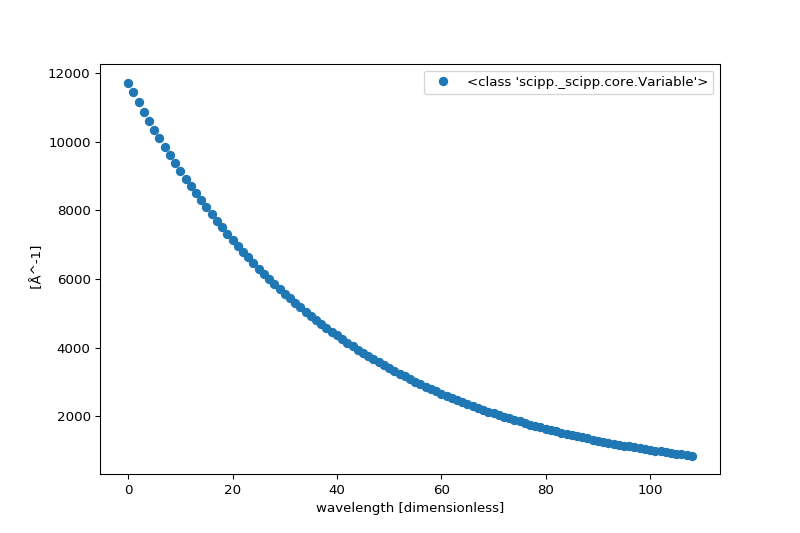

CPU times: user 2.8 s, sys: 276 ms, total: 3.07 s
Wall time: 3.09 s


In [448]:
%%time
sample_q1d= q1d(data=sample, transmission=sample_trans)


In [224]:
    mv =np.loadtxt('/home/spu92482/sources/loki_tube_scripts/data_reduction_scripts/q_res_values_mantid.txt')
    mx =np.loadtxt('/home/spu92482/sources/loki_tube_scripts/data_reduction_scripts/q_res_values_mantid_x.txt')
    print(mx.shape)

    

(114698, 111)


<IPython.core.display.Javascript object>


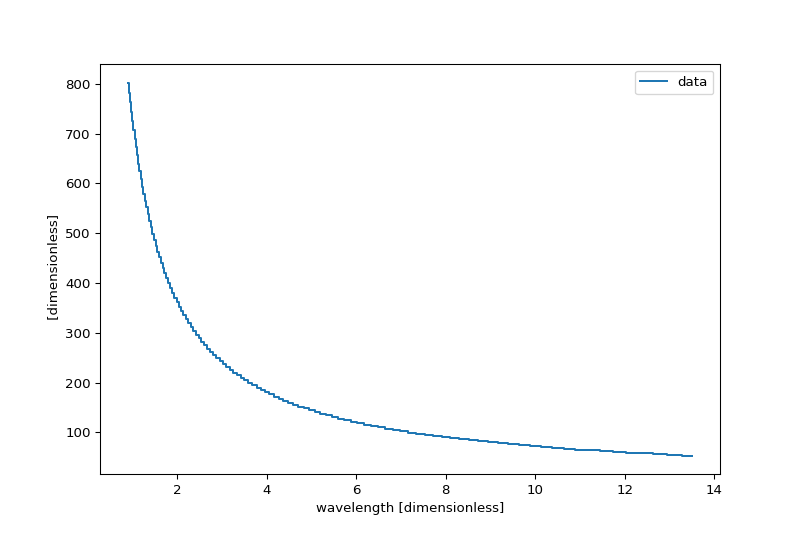

In [271]:
ds = sc.Dataset()
ds.coords['wavelength'] = sc.Variable(['wavelength'],values=mx[0,:])
ds.coords['spectrum'] = sc.Variable(['spectrum'],values=np.arange(len(mx[:,0])))
ds['data'] = sc.Variable(['spectrum','wavelength'], values=mv)
ds = sc.sum(ds['data']['spectrum',4:], 'spectrum')
plot(ds)

In [ ]:
%%time
sample_q1d = q1d(data=sample, transmission=sample_trans)
background_q1d = q1d(data=background, transmission=background_trans)
reduced = sample_q1d - background_q1d

reduced.attrs['UserFile'] = sc.Variable(
    value='USER_Raspino_191E_BCSLarmor_24Feb2020_v1.txt')
reduced.attrs['Transmission'] = sc.Variable(
    value=f'{sample_transmission_run_number}_trans_sample_0.9_13.5_unfitted')
reduced.attrs['TransmissionCan'] = sc.Variable(
    value=f'{background_transmission_run_number}_trans_can_0.9_13.5_unfitted')

In [ ]:
reduced

In [ ]:
from scipp.plot import plot
values, stddev = np.loadtxt("mantid_reduced.txt")
q = np.loadtxt("mantid_reduced_q.txt")

mantid = sc.DataArray(data=sc.Variable(['Q'],
                                       values=values,
                                       variances=stddev*stddev),
                      coords={'Q': sc.Variable(['Q'], unit=sc.units.one/sc.units.angstrom, values=q)})
mantid = sc.rebin(mantid, 'Q', reduced.coords['Q'])

ds = sc.Dataset({'mantid': mantid, 'scipp': reduced})
plot(ds, logy=True)